In [1]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

# Data

First we need to generate some Data. This data should be suitable for binary classification, not too complex but also not linearly seperable.

In [3]:
def pos_case():
    return (1,
            random.gauss(1, 1),
            random.gauss(1, 1))

def neg_case():
    if random.random() > 0.5:
        return (0,
            random.gauss(5, 1),
            random.gauss(2.5, 2.5))
    else:
        return (0,
            random.gauss(2.5, 2.5),
            random.gauss(5, 1))

def data_generator():
    if random.random() > 0.5:
        return pos_case()
    else:
        return neg_case()

In [4]:
random.seed(42)
data = pd.DataFrame(
    [data_generator() for _ in range(3000)],
    columns = ['y', 'x_1', 'x_2'])

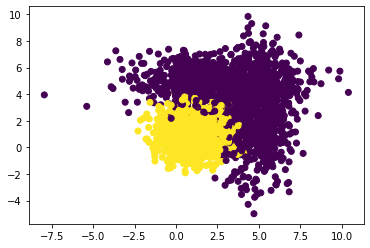

In [5]:
plt.scatter(data['x_1'], data['x_2'], c = data['y'])
plt.show()

# Modeling
As we can see in the above plot, the data is not linearly seperable, so we need a more complex model. An ANN with one hidden layer should be able to do the Job.

<img src="model.png" alt="Model Architecture" width="500"/>

For the output layer we use the sigmoid function as activation, in the hidden layer we use ReLu. 

Now, optimisation allways calls for a 'What?' and a 'How?'. For ANNs the what is the loss, or rather the **surrogate loss**. This is a proxy for the actuall loss, with nicer analytical attributes. The how is a search across the parameter space.

## Loss
In the spirit of Backpropagation we will start at the output node for specifying the loss.
For binary classification with sigmoid activation we can rewrite the loss as a softplus function and obtain the following result, as demonstrated in section 6.2.2.2 of the book.

<img src="6_26.png" alt="Basic Loss" width="500"/>
<img src="softplus.png" alt="Basic Loss" width="500"/>

Here z represents the input to the output layer. So lets expand it for the hidden layer.

<img src="J_hidden.png" alt="Basic Loss" width="500"/>

In the same fashion we can also resolve **h** to obtain the full loss function. Obviously, vecor notation would be more concise but in this way it's easier for the next step.

<img src="J_full.png" alt="Basic Loss" width="500"/>
 

## Gradient
Now, given the loss, we can turn towards the 'How?'. Most methods are based on the gradient of the function, so the analytical rate of change within the parameter space. However, there are many other approaches and hauristics, which will not be discussed here. Before we derive the acctual gradient, we will define some short hands.

<img src="D_support.png" alt="Basic Loss" width="500"/>

With these short hands we can derrive the partial derrivative for `theta_(1,1)` easily. 

<img src="D_t_11_new.png" alt="Basic Loss" width="500"/>

For `theta_(1,2)` we just need to replace `x_1` with `x_2`. For the second node in the hidden layer, the parameter of the output layer are adapted and for the bias `x_i` is droped.

The parameters of the output layer have the following derrivatives:

<img src="D_t_o1.png" alt="Basic Loss" width="500"/>

Here the adaption for `theta_(O,2)` is achived by adopting the `max(...)`

Finally we have the Derrivative for `theta_(O,3)`:

<img src="D_t_o3.png" alt="Basic Loss" width="500"/>







## Code
Based on the derived Loss and Gradient we can implement the functions as code.

In [6]:
def a(x, y, theta):
    return ( (1-2*y)
        *(  max(0, x[0]*theta[0][0] + x[1]*theta[0][1] + theta[0][2]) * theta[2][0]
          + max(0, x[0]*theta[1][0] + x[1]*theta[1][1] + theta[1][2]) * theta[2][1]
          + theta[2][2]
        ) 
    )

def b(x, y, theta):
    return 1 + np.exp(a(x, y, theta))

def J(x, y, theta):
    return np.log(b(x, y, theta))


In [7]:
def d_hidden(x, y, theta, node, par):
    if (x[0]*theta[node][0] + x[1]*theta[node][1] + theta[node][2]) < 0:
        return 0
    if par == 2:
        return (np.exp(a(x, y, theta)) * (1 - 2*y) * theta[2][node])/b(x, y, theta)
    return (np.exp(a(x, y, theta)) * (1 - 2*y) * x[par] * theta[2][node])/b(x, y, theta)

def d_out(x, y, theta, par):
    if par == 2:
        return (np.exp(a(x, y, theta)) * (1 - 2*y))/b(x, y, theta)
    return (np.exp(a(x, y, theta)) 
            * (1 - 2*y) 
            * max(0, x[0]*theta[par][0] + x[1]*theta[par][1] + theta[par][2]))/b(x, y, theta)

def gradient(x, y, theta):
    return (
        (d_hidden(x, y, theta, 0, 0),
        d_hidden(x, y, theta, 0, 1),
        d_hidden(x, y, theta, 0, 2),),
        (d_hidden(x, y, theta, 1, 0),
        d_hidden(x, y, theta, 1, 1),
        d_hidden(x, y, theta, 1, 2),),
        (d_out(x, y, theta, 0),
        d_out(x, y, theta, 1), 
        d_out(x, y, theta, 2),),
    )

## Initalisation
All Algorithms we considder, can only improve an existing solution, so to do so, we need to select an inital pint in the parameter space. Initalisation of the parameters is a topic on its own, so for now we just use small random values for all 9 parameters.

In [8]:
PARAMS = [[random.gauss(0, 0.1) for _ in range(3)] for _ in range(3)]

# Optimisation
Given the basics, we can now considder different approaches for optimisation.

## Stochastic Gradient Decent


<img src="SGD.png" alt="Basic Loss" width="500"/>

SGD is the mother of all algorithms we consider for now.

In [14]:
BATCHSIZE = 50

In [24]:
def SGD_LR(k, lr=0.1, tau = 300):
    if k <= tau:
        return (1-(k/tau))*lr + (k/tau)*0.01*lr
    else:
        return 0.01*lr

def mean_gradient(data, theta, batch, batch_size):
    gradient_sum = [[0,0,0], [0,0,0], [0,0,0]]
    for i in range(batch_size): 
        gradient_sum = np.add(
            gradient_sum,
            gradient(
                [data['x_1'][batch + i], data['x_2'][batch + i]],
                data['y'][batch + i],
                theta
            )
        )
    return gradient_sum / batch_size

def evaluate(data, theta):
    loss = 0
    for i in range(2500, 3000, 1):
        loss += J(
            [data['x_1'][i], data['x_2'][i]],
            data['y'][i],
            theta
        )

    return {'avg_loss': loss/500}

In [25]:
SGD_gradient_updates = []
SGD_thetas = []

theta = PARAMS.copy()
for epoch in range(30):
    for batch in range(0, 2500, BATCHSIZE):
        g_hat = mean_gradient(data, theta, batch, BATCHSIZE)
        theta = np.add(
            theta,
            -1 * SGD_LR(batch/BATCHSIZE) * g_hat
        )
        SGD_thetas.append(theta)
        SGD_gradient_updates.append(SGD_LR(batch/BATCHSIZE) * g_hat)
    print(evaluate(data, theta))

{'avg_loss': 0.6879905949408173}
{'avg_loss': 0.6729755899251858}
{'avg_loss': 0.629965932995199}
{'avg_loss': 0.5448545247819442}
{'avg_loss': 0.44862915352713556}
{'avg_loss': 0.37595209279200165}
{'avg_loss': 0.32784861511574037}
{'avg_loss': 0.2969071028175909}
{'avg_loss': 0.27637479759923633}
{'avg_loss': 0.26234150395515404}
{'avg_loss': 0.2522536770819669}
{'avg_loss': 0.24484662016315686}
{'avg_loss': 0.2392840280301346}
{'avg_loss': 0.23458109360287888}
{'avg_loss': 0.23050935794987384}
{'avg_loss': 0.22768687488665837}
{'avg_loss': 0.22520219400325134}
{'avg_loss': 0.22313770297106134}
{'avg_loss': 0.22155249282811937}
{'avg_loss': 0.21997650914095646}
{'avg_loss': 0.21852850442965419}
{'avg_loss': 0.21744576147807773}
{'avg_loss': 0.21638816301548053}
{'avg_loss': 0.21556498271611862}
{'avg_loss': 0.21482427483688837}
{'avg_loss': 0.21415198664321589}
{'avg_loss': 0.21354011642398082}
{'avg_loss': 0.21298392292914983}
{'avg_loss': 0.2124542306693234}
{'avg_loss': 0.21194263

## Momentum
A measure, how difficult it is to stop a moving object (https://www.youtube.com/watch?v=DxKelGugDa8 Nice video particularly relevant until 2:35)

In the context of optimisation the momentum smoothes out the optimisation trajectory, counter acting variance of the gradient

<img src="momentum.png" alt="Basic Loss" width="500"/>

